In [18]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
np.logspace(np.log10(80),np.log10(178),10)

array([ 80.        ,  87.43437519,  95.55962457, 104.43995085,
       114.1455231 , 124.75303116, 136.34629167, 149.01691027,
       162.86500554, 178.        ])

In [20]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY'] ['HPC']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [0] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)

plot_error_bars = True

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [21]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)

    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    
    if encoding_mode == 1:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        start_cutoff = 300 # times (in s) relative to word_on 
        end_cutoff = 1300 
        
    elif encoding_mode == 0:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2.0, 2.0, 200)
        start_cutoff = -1000
        end_cutoff = 0      
        
    # convert time ranges to samples
    sr_factor = 1000/fs
    # data taken is from -1.7 to 3.3 s from word_on so account for that by adding 1700 ms
    start_cutoff = 0
    end_cutoff = 2500 # just take the whole range of data to better estimate Morlet
#     start_cutoff = int((1700+start_cutoff-buffer)/sr_factor) # this comes to 0:2500 anyway
#     end_cutoff = int((1700+end_cutoff+buffer)/sr_factor)     # ...so just index in time from here
    
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C
Generating figures for run_mode:  0


In [22]:
# info
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'clust', 'raw', 'elec_by_elec_correlation', 'serial_pos', 'recall_pos', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'clust_int'])

(5667, 2000)

(5667, 3000)

(2, 5667, 250)

[[33.5, 75], [80, 120]]

array(['R1065J', 'R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'],
      dtype='<U6')

In [23]:
gamma_sd_thresh = 1.5
remove_first_recalls = 1 # if looking at recall might want to remove first recall of each list

# select a patient?
patient_idx = -1 # -1 means all

if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])

# if recalls remove the intrusions
if encoding_mode == 0:
    if remove_first_recalls:
        sub_clust_idxs = (sub_idxs) & (clust!=0) & (dd_trials['recall_pos']!=1)
    else:
        sub_clust_idxs = (sub_idxs) & (clust!=0)
else:
    sub_clust_idxs = sub_idxs
      
# update each variable with indices
sub_ripples = dd_trials['ripple'][sub_clust_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
sub_Zs = power_z[:,sub_clust_idxs,:]
clust = clust[sub_clust_idxs]
np.shape(sub_Zs)

z_factor = sr_factor*10 # z_score was decimated 10x
if encoding_mode == 1:
    ripple_start_offset = -700 # # note only +700 since ripple_trials go from -0.7 to 2.3 s (no buffers)
    ripple_analysis_start = 300 # time in ms
    ripple_analysis_end = 1300 # time in ms
    
    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((1700+ripple_analysis_start)/z_factor),int((1700+ripple_analysis_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s
    z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>gamma_sd_thresh
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>gamma_sd_thresh    
    
elif encoding_mode == 0:
    ripple_start_offset = -2000 # ripple matrix 2000 ms on either side of recall
    ripple_analysis_start = -1900 # time in ms
    ripple_analysis_end = -100 # time in ms    

    # average z-score over time for same range as ripples
    gamma_time_range = slice(int((2000+ripple_analysis_start)/z_factor),int((2000+ripple_analysis_end)/z_factor)) # +2000 since goes from -3 to 3 s
    z_low_gamma_trials = np.mean(sub_Zs[0,:,gamma_time_range],1)>gamma_sd_thresh
    z_high_gamma_trials = np.mean(sub_Zs[1,:,gamma_time_range],1)>gamma_sd_thresh      

ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_analysis_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_analysis_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(sub_clust_idxs),2)}% of total')


Number of trials: 5667 from the following subs:


array(['R1065J', 'R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'],
      dtype='<U6')

(2, 3719, 250)

1688 trials have ripples which is 45.39% of total


In [24]:
start_array,_ = getStartEndArrays(sub_ripples)

# first bin has artificially high number due to how start_srray works
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

start array shape: (3719, 1999)


# ripples after removing low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


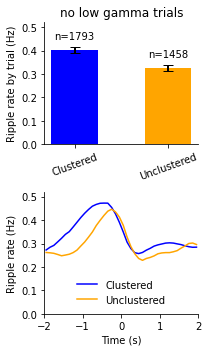

In [32]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.52)
trial_select = ~z_low_gamma_trials
    

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('no low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.04, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

# ripples only for + low gamma trials

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: RuntimeWarning: invalid value encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: RuntimeWarning: divide by zero encountered in true_divide
  norm_count = count/np.array((num_trials*binsize/1000))


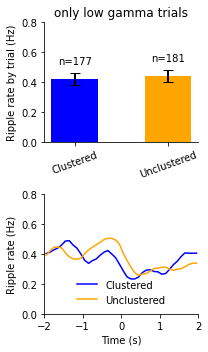

In [33]:
# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.8)
trial_select = z_low_gamma_trials

ripple_swarm_start = int((-ripple_start_offset+ripple_analysis_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_analysis_end)/sr_factor)
ripple_swarm_duration = (ripple_analysis_end-ripple_analysis_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

if encoding_mode == 1:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
           np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]
    fig = plt.figure(figsize=(4, 5))
elif encoding_mode == 0:
    means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered)]
    ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
           np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered))]    
    fig = plt.figure(figsize=(3, 5))

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
if encoding_mode == 1:
    xlabels = ['Clustered', 'Unclustered', 'Not Recalled']
    xcolors = [palette['Clustered'], palette['Unclustered'], palette['Not Recalled']]
elif encoding_mode == 0:
    xlabels = ['Clustered', 'Unclustered']
    xcolors = [palette['Clustered'], palette['Unclustered']]
bars = ax_bar.bar(x=xlabels, 
                  height=means, 
                  color=xcolors, 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.set_title('only low gamma trials')

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.085, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
if encoding_mode == 1:
    ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
    ax_psth.axvline(x=0.0, color='black', linestyle='--')
    ax_psth.axvline(x=1.6, color='black', linestyle='--')
    ax_psth.set_xlim(-0.25, 2.05)
elif encoding_mode == 0:
    ax_psth.set_xlim(-2.0, 2.0)
ax_psth.set_xlabel('Time (s)')
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (clust > 1).astype(int),
    'clust_unclustered': (clust < 0).astype(int),
    'clust_not_recalled': (clust == 0).astype(int),
    'session': dd_trials['sess'][sub_clust_idxs],
    'subject': dd_trials['subj'][sub_clust_idxs],
    'low_gamma': z_low_gamma_trials,
    'high_gamma': z_high_gamma_trials
})

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
if encoding_mode == 1:
    formula = "ripple_rate ~ clust_clustered + clust_unclustered"
elif encoding_mode == 0:
    formula = "ripple_rate ~ clust_clustered" # since not recalled doesn't exist
model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ripple_rate
No. Observations: 3719    Method:             REML       
No. Groups:       6       Scale:              0.7863     
Min. group size:  16      Log-Likelihood:     -4846.8268 
Max. group size:  2268    Converged:          Yes        
Mean group size:  619.8                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.678    0.046 14.734 0.000  0.588  0.768
clust_clustered 0.130    0.030  4.375 0.000  0.072  0.189
session Var     0.021    0.012                           



In [30]:
if encoding_mode == 1:
    formula = "ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)"
elif encoding_mode == 0:
    formula = "ripple_rate ~ low_gamma*clust_clustered" # since not recalled doesn't exist

model = mixedlm(
    formula=formula,data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ripple_rate
No. Observations:        3719          Method:                   REML       
No. Groups:              6             Scale:                    0.7842     
Min. group size:         16            Log-Likelihood:           -4844.4405 
Max. group size:         2268          Converged:                Yes        
Mean group size:         619.8                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.655    0.047 13.904 0.000  0.563  0.748
low_gamma[T.True]                  0.233    0.069  3.397 0.001  0.099  0.367
clust_clustered                    0.153    0.031  4.873 0.000  0.091  0.214
low_gamma[T.True]:c